In [1]:
from imp import reload
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import datetime
from  tqdm import tqdm
import math

import data_generator
import hparams
import model_unet
import numpy as np
from loss_function import CrossEntropyLoss_Origin
import utils
reload(utils)
import evaluate

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [11]:
# 一个epoch的训练+测试
def train(dataloader, model, loss_fn, optimizer, scheduler, out_floor):
    model.train()
    size = len(dataloader.dataset)
    batch_num = math.ceil(size/dataloader.batch_size)
    loss_total = 0
    
    for batch, (X, y) in tqdm(enumerate(dataloader)): # 每次返回一个batch
        X, y = X.to(device), y.to(device)
        
        batch_size = len(X)

        # Compute prediction error
        pred = model(X, out_floor)
        
        if out_floor == 0:
            loss = loss_fn(pred, y)
        else:
            # downsample y
            y_downsample = utils.downsample(y, out_floor)
            loss = loss_fn(pred, y_downsample)
            
        loss_total += loss.item()
            
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch+1) % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Avg loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    scheduler.step()
    return loss_total/batch_num
            
def test(dataloader, model, loss_fn, out_floor):
    size = len(dataloader.dataset)
    batch_num = math.ceil(size/dataloader.batch_size)
    
    model.eval()
    test_loss = 0
    oa_avg, vr_avg, vfa_avg, rpa_avg, rca_avg = 0, 0, 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            Xpred = model(X, out_floor)
            Xout = utils.salience_to_output(Xpred, threshold=hparams.threshold)
            
            if out_floor == 0:
                loss = loss_fn(Xpred, y)
                oa, vr, vfa, rpa, rca = evaluate.evaluate(Xout, y, out_floor)
            else:
                # downsample y
                y_downsample = utils.downsample(y, out_floor)
                loss = loss_fn(Xpred, y_downsample)
                oa, vr, vfa, rpa, rca = evaluate.evaluate(Xout, y_downsample, out_floor)
            
            test_loss += loss.item()
            oa_avg += oa
            vr_avg += vr
            vfa_avg += vfa
            rpa_avg += rpa
            rca_avg += rca
            
    test_loss /= batch_num # 每张图的loss
    
    oa_avg /= batch_num
    vr_avg /= batch_num
    vfa_avg /= batch_num
    rpa_avg /= batch_num
    rca_avg /= batch_num
    
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")
    print(f"Test OA\t{oa_avg:.4f}\tVR\t{vr_avg:.4f}\tVFA\t{vfa_avg:.4f}\tRPA\t{rpa_avg:.4f}\tRCA\t{rca_avg:.4f}\n")
    
    return test_loss, oa_avg, vr_avg, vfa_avg, rpa_avg, rca_avg

# split data, generate train/test_dataloader

In [3]:
'''
fold_index = list(range(10))
random.shuffle(fold_index)
test_fold_index = fold_index[0]
validation_fold_index = fold_index[1]
train_fold_index_list = fold_index[2:]
'''
train_fold_index_list = hparams.train_set_fold_index
valid_fold_index_list = hparams.validation_set_fold_index
test_fold_index_list = hparams.test_set_fold_index

# have a try :)  Train

In [4]:
# prepare


print(f'{datetime.datetime.now()} - Preparing train_dataloader...')
train_dataloader = data_generator.source_index_to_chunk_list(source_list=train_fold_index_list,
                                                             data_chunks_duration_in_bins=hparams.data_chunks_duration_in_bins,
                                                             data_chunks_overlap_in_bins=hparams.data_chunks_overlap_in_bins_for_training)[0:3000]
train_dataloader = DataLoader(train_dataloader, batch_size=16, shuffle=True)


print(f'{datetime.datetime.now()} - Preparing valid_dataloader...')
valid_dataloader = data_generator.source_index_to_chunk_list(source_list=valid_fold_index_list,
                                                             data_chunks_duration_in_bins=hparams.data_chunks_duration_in_bins,
                                                             data_chunks_overlap_in_bins=hparams.data_chunks_overlap_in_bins_for_training)#[0:32]
valid_dataloader = DataLoader(valid_dataloader, batch_size=16, shuffle=False)

print(f'{datetime.datetime.now()} - Preparing test_dataloader...')
test_dataloader = data_generator.source_index_to_chunk_list(source_list=test_fold_index_list,
                                                             data_chunks_duration_in_bins=hparams.data_chunks_duration_in_bins,
                                                             data_chunks_overlap_in_bins=hparams.data_chunks_overlap_in_bins_for_training)#[0:32]
test_dataloader = DataLoader(test_dataloader, batch_size=16, shuffle=True)

2021-07-11 21:54:26.589489 - Preparing train_dataloader...
2021-07-11 21:54:36.036899 - Preparing valid_dataloader...
2021-07-11 21:54:36.380012 - Preparing test_dataloader...


In [102]:
# 测试模型在测试集上的效果
model = model_unet.UNet(device=device)
model = torch.load('./model/test/model_floor3_best.pth')

In [103]:
loss_fn = CrossEntropyLoss_Origin().to(device)

test(test_dataloader, model, loss_fn, 3)

Test Error: Avg loss: 1.773021 

Test OA	0.3865	VR	1.0000	VFA	0.9923	RPA	0.4683	RCA	0.5001



(1.7730205594276895,
 0.3865182436611007,
 1.0,
 0.992347323820161,
 0.4683368412339763,
 0.5000545850783203)

In [ ]:
# 损失函数
'''
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
scheduler_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94, verbose=True)
scheduler_stop = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', threshold=1e-4, factor=-1, patience=10)
'''

loss_fn = CrossEntropyLoss_Origin().to(device)

# 逐个比较损失

In [161]:
import torch.nn.functional as func

class CrossEntropyLoss_for_FA_CE(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss_for_FA_CE, self).__init__()
        return
    def forward(self, output, one_hot):
        '''
        output: network output(not softmax yet)
                shape: [N, 1, f, t]
        one_hot: ground truth(has not been gaussian blurred)
                shape: [N, f, t]
        [OUTPUT]是一个batch中不同样本的均值
        '''
        output = output.squeeze(dim=1) # output: [N, f, t]
        output_minus = output - output.max() # 防止softmax溢出
        sm = func.softmax(output_minus, dim=-2)
        
        # 对one-hot进行处理，没有label的全零列改成1/360

        none_zero_lines = one_hot.bool().any(1).reshape(-1)
        one_hot = one_hot.float()
        index0 = torch.tensor([list(range(one_hot.shape[0]))]*one_hot.shape[2]).T.reshape(-1)[none_zero_lines == False]
        index2 = torch.tensor([list(range(one_hot.shape[2]))]*one_hot.shape[0]).reshape(-1)[none_zero_lines == False]
        one_hot[index0, :, index2] = 1/one_hot.shape[1]
        
        return (-torch.log(sm)*one_hot).sum()

Xpred: torch.Size([2, 1, 45, 33])
y_downsample: torch.Size([2, 45, 33])
------------
tensor(222.7886, device='cuda:0')
tensor(2.6658, device='cuda:0')
(0.19696969696969696, 1.0, 1.0, 0.25, 0.28846153846153844)


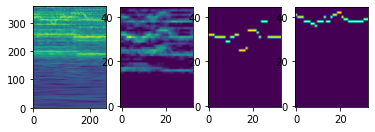

In [162]:
import evaluate
reload(evaluate)

out_floor = 3

model.eval()
model_loss = 0

loss_fn = CrossEntropyLoss_for_FA_CE().to(device)
loss_fn_2 = CrossEntropyLoss_Origin().to(device)

with torch.no_grad():
    for a, b in test_dataloader:
        X, y = a.to(device), b.to(device)
        
        X = X[0:2]
        y = y[0:2]
        
        Xpred = model(X, out_floor)
        Xshow = utils.salience_to_output(Xpred, threshold=0.05)
        y_downsample = utils.downsample(y, out_floor).int()
        print(f'Xpred: {Xpred.shape}')
        print(f'y_downsample: {y_downsample.shape}')
        
        plt.subplot(141)
        plt.imshow(X[0][0].cpu(), origin='lower')
        plt.subplot(142)
        plt.imshow(Xpred[0][0].cpu(), origin='lower')
        plt.subplot(143)
        plt.imshow(Xshow[0][0].cpu(), origin='lower')
        plt.subplot(144)
        plt.imshow(y_downsample[0].cpu(), origin='lower')
        
        print('------------')
        
        print(loss_fn(Xpred, y_downsample))
        print(loss_fn_2(Xpred, y_downsample))
        print(evaluate.evaluate(Xshow, y_downsample, 3))

        break

In [ ]:
plt.subplot(131)
plt.imshow(Xpred[0][0].cpu(), origin='lower')
plt.subplot(132)
plt.imshow(Xshow[0][0].cpu(), origin='lower')
plt.subplot(133)
plt.imshow(y_downsample[0].cpu(), origin='lower')

In [ ]:
loss_fn(Xpred, y_downsample)

In [ ]:
import loss_function.CrossEntropyLoss_Origin as loss

In [ ]:
for X, y in train_dataloader:

    y_downsample = utils.downsample(y, 3)
    
    break

plt.figure(figsize=(10,10))

plt.subplot(231)
plt.imshow(y[0], origin='lower')
plt.subplot(232)
plt.imshow(y_downsample[0], origin='lower')

plt.subplot(234)
plt.imshow(y[1], origin='lower')
plt.subplot(235)
plt.imshow(y_downsample[1], origin='lower')
plt.show()

In [ ]:
loss_fn = CrossEntropyLoss_Origin().to(device)

model.eval()
model2.eval()

X, y = None, None
for a,b in tqdm(train_dataloader):
    X, y = a.to(device), b.to(device)

    Xpred = model(X, 2)
    y_downsample = utils.downsample(y, 2)

    temp = Xpred[0,0].detach().to('cpu').numpy()

    clean = utils.salience_to_output(temp, threshold=0)


    Xpred2 = model2(X, 2)

    temp2 = Xpred2[0,0].detach().to('cpu').numpy()

    clean2 = utils.salience_to_output(temp2, threshold=0)
    
    if loss_fn(Xpred, y_downsample) + 10 < loss_fn(Xpred2, y_downsample):
    
        plt.subplot(231)
        plt.imshow(y_downsample[0].detach().to('cpu').numpy(), origin='lower')
        plt.subplot(232)
        plt.imshow(temp, origin='lower')
        plt.subplot(233)
        plt.imshow(clean, origin='lower')

        plt.subplot(234)
        plt.imshow(y_downsample[0].detach().to('cpu').numpy(), origin='lower')
        plt.subplot(235)
        plt.imshow(temp2, origin='lower')
        plt.subplot(236)
        plt.imshow(clean2, origin='lower')
        plt.show()
        print(loss_fn(Xpred, y_downsample) , loss_fn(Xpred2, y_downsample))

# 保存模型

In [ ]:
torch.save(model.state_dict(), 'model_12epoch.pth')

model = model_unet.UNet(device=device)
model.load_state_dict(torch.load('model_9epoch.pth'))

In [ ]:
try:
    !jupyter nbconvert --to python train_the_model.ipynb
except:
    pass